In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
import torchvision
from torchvision import datasets, models, transforms
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
import random
import time
from PIL import Image

In [2]:
test = pd.read_csv('test_large_4.0.csv')

In [3]:
test

,path,font,char,code,label
0,char\鏘字\鏘字 草书 毛泽东.jpg,3,锵,1803,3 1803
1,char\消字\消字 隶书 武威简.jpg,1,消,951,1 951
2,char\薑字\薑字 篆书 吴昌硕.jpg,4,姜,1462,4 1462
3,char\赠字\赠字 隶书 顾蔼吉.jpg,1,赠,1652,1 1652
4,char\绮字\绮字 行书 近人.jpg,2,绮,1314,2 1314
...,...,...,...,...,...
15631,char\斋字\斋字 草书 敬世江.jpg,3,斋,737,3 737
15632,char\帘字\帘字 行书 汇辑.jpg,2,帘,494,2 494
15633,char\薛字\薛字 行书 陈献章.jpg,2,薛,1463,2 1463
15634,char\钿字\钿字 行书 董其昌.jpg,2,钿,1813,2 1813


In [4]:
train= pd.read_csv('train_large_4.0.csv')

In [5]:
train

,path,font,char,code,label
0,char\瑞字\瑞字 楷书 柳公权.jpg,0,瑞,1087,0 1087
1,char\越字\越字 隶书 钱松.jpg,1,越,1659,1 1659
2,char\胡字\胡字 草书 沈学植.jpg,3,胡,1366,3 1366
3,char\攸字\攸字 行书 饶介.jpg,2,攸,725,2 725
4,char\概字\概字 草书 毛泽东.jpg,3,概,855,3 855
...,...,...,...,...,...
51456,char\锥字\锥字 楷书 柳公权.jpg,0,锥,1817,0 1817
51457,char\敝字\敝字 篆书 说文解字.jpg,4,敝,732,4 732
51458,char\区字\区字 篆书 吴昌硕.jpg,4,区,220,4 220
51459,char\吟字\吟字 楷书 王知敬.jpg,0,吟,272,0 272


In [7]:
class MyModel(nn.Module):
    def __init__(self, num_classes1):
        super(MyModel, self).__init__()
        self.eps = 1
        self.k=torch.FloatTensor([10])
        self.model_resnet = models.resnet50(pretrained=True)
        num_ftrs = self.model_resnet.fc.in_features
        self.model_resnet.fc = nn.Identity()
        self.fc1 = nn.Linear(num_ftrs, num_classes1)
        #self.fc2 = nn.Linear(4096, num_classes2)
        #self.softmax = nn.Softmax(dim=1)
        #self.embed =nn.Embedding(5, 2048)

    def font_code(self,y):
        ret=torch.FloatTensor().to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        for i, x in enumerate(y):
            result=self.embed(x)
            result=torch.reshape(result, (1,2048))
            ret=torch.cat((ret, result))
        return ret
    def predict_font_code(self,y):
        ret=torch.FloatTensor().to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        for i, x in enumerate(y):
            num=torch.topk(x,1)[1]
            result=self.embed(num)
            result=torch.reshape(result, (1,2048))
            ret=torch.cat((ret, result))
        return ret
    def forward(self, x,y):
        x = self.model_resnet(x)
        out1 = self.fc1(x)
        #p = torch.rand(1).item()
        #font = self.predict_font_code(out1)
        #if p < self.k / (self.k + torch.exp(self.eps / self.k)):
        #    font = self.font_code(y)
        #else:
        #    font = self.predict_font_code(out1)
        #font = self.predict_font_code(out1)
        #self.eps +=1
        #combined = torch.cat((x.view(x.size(0), -1),font.view(font.size(0), -1)), dim=1)
        #out2 = self.fc2(combined)
        return out1

In [8]:
model = MyModel(5)

In [9]:
def training(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_loss1 = 0
    epoch_loss2 = 0
    epoch_acc1 = 0
    epoch_acc2 = 0
    epoch_acc3 = 0
    model.train()
    
    for x, y1 in iterator:
        
        x = x.to(device)
        y1 = y1.to(device)
        #y2 = y2.to(device)
        
        optimizer.zero_grad()
                
        outputs = model(x,y1)
        
        loss1 = criterion(outputs, y1)
        #loss2 = criterion(outputs[1], y2)
        loss = loss1  
        
        acc1 = calculate_accuracy(outputs, y1)
        #acc2 = calculate_accuracy(outputs[1], y2)
        #gender_corrects += torch.sum(torch.topk(outputs[0], 1)[1] == torch.topk(y1, 1)[1])
        #acc3 = calculate_10_accuracy(outputs, y1)
        
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        #epoch_loss1 += loss1.item()
        #epoch_loss2 += loss2.item()
        epoch_acc1 += acc1.item()
        #epoch_acc2 += acc2.item()
        #epoch_acc3 += acc3.item()
    return epoch_loss / len(iterator), epoch_acc1 / len(iterator)

In [10]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_loss1 = 0
    epoch_loss2 = 0
    epoch_acc1 = 0
    epoch_acc2 = 0
    epoch_acc3 = 0
    model.eval()
    
    with torch.no_grad():
    
        for x, y1 in iterator:
        
            x = x.to(device)
            y1 = y1.to(device)
            #y2 = y2.to(device)
        
            optimizer.zero_grad()
                
            outputs = model(x,y1)
        
            loss1 = criterion(outputs, y1)
            #loss2 = criterion(outputs[1], y2)
            loss = loss1 
        
            acc1 = calculate_accuracy(outputs, y1)
            #acc2 = calculate_accuracy(outputs[1], y2)
            #acc3 = calculate_10_accuracy(outputs, y1)

            epoch_loss += loss.item()
            #epoch_loss1 += loss1.item()
            #epoch_loss2 += loss2.item()
            epoch_acc1 += acc1.item()
            #epoch_acc2 += acc2.item()
            #epoch_acc3 += acc3.item()
        
    return epoch_loss / len(iterator), epoch_acc1 / len(iterator)

In [11]:
preprocess = transforms.Compose([
   transforms.Resize(256),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   transforms.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
   )
])

In [22]:
class MultiTaskDataset():
    def __init__(self,df):
        self.paths = list(df.path)
        self.labels = list(df.label)

    def __len__(self): return len(self.paths)

    def __getitem__(self,idx):
        #dealing with the image
        img = Image.open(self.paths[idx]).convert('RGB')
        img = preprocess(img)


        #dealing with the labels
        labels = self.labels[idx].split(" ")
        font = torch.tensor(int(labels[0]), dtype=torch.int64)
        #code = torch.tensor(int(labels[1]), dtype=torch.int64)
        
        return img.data,font

    def show(self,idx):
        x,y = self.__getitem__(idx)
        font,code = y
        stds = np.array([0.229, 0.224, 0.225])
        means = np.array([0.485, 0.456, 0.406])
        img = ((x.numpy().transpose((1,2,0))*stds + means)*255).astype(np.uint8)
        plt.imshow(img)
        plt.title("{} {}".format(font.item(), code.item()))

In [24]:
train_ds = MultiTaskDataset(train)

tr_dataloader=torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=0)

In [25]:
test_ds = MultiTaskDataset(test)

test_dataloader=torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=True, num_workers=0)

In [26]:
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [27]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [28]:
def calculate_10_accuracy(y_pred, y):
    top_pred = torch.topk(y_pred,10)[1]
    y_resize = y.view(-1,1)
    correct = torch.eq(top_pred, y_resize).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [29]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [20]:
loss,char_acc=training(model, tr_dataloader, optimizer, criterion, device)

In [25]:
ts_loss,ts_char_acc=evaluate(model, test_dataloader, criterion, device)

In [27]:
ts_char_acc

0.00548469387755102

In [28]:
list_tr_loss.append(loss)
list_char_acc.append(char_acc)
list_ts_loss.append(ts_loss)
list_ts_char_acc.append(ts_char_acc)

In [31]:
list_tr_loss=[]
list_font_loss=[]
list_char_loss=[]
list_font_acc=[]
list_char_acc=[]
list_char_10_acc=[]
list_ts_loss=[]
list_ts_font_loss=[]
list_ts_char_loss=[]
list_ts_font_acc=[]
list_ts_char_acc=[]
list_ts_char_10_acc=[]

In [32]:
list_tr_loss.append(loss)
list_font_acc.append(font_acc)
list_ts_loss.append(ts_loss)
list_ts_font_acc.append(ts_font_acc)

In [33]:
for i in range(9):
    since=time.time()
    loss,font_acc=training(model, tr_dataloader, optimizer, criterion, device)
    ts_loss,ts_font_acc=evaluate(model, test_dataloader, criterion, device)
    mins,secs=epoch_time(since,time.time())
    list_tr_loss.append(loss)
    list_font_acc.append(font_acc)
    
    list_ts_loss.append(ts_loss)
    list_ts_font_acc.append(ts_font_acc)
    
    print('epochs:'+ str(i+1))
    print('min:'+str(mins)+' '+'sec:'+str(secs))
    print('training_loss:'+str(round(loss, 5))+' font_accuracy:'+str(round(font_acc, 5)))
    print('test_loss:'+str(round(ts_loss, 5))+' font_accuracy:'+str(round(ts_font_acc, 5)))

epochs:1
min:10 sec:19
training_loss:0.3305 font_accuracy:0.86264
test_loss:0.37486 font_accuracy:0.84909
epochs:2
min:10 sec:35
training_loss:0.28813 font_accuracy:0.88221
test_loss:0.38048 font_accuracy:0.83805
epochs:3
min:10 sec:39
training_loss:0.26338 font_accuracy:0.89226
test_loss:0.37593 font_accuracy:0.84925
epochs:4
min:10 sec:40
training_loss:0.23177 font_accuracy:0.90538
test_loss:0.37892 font_accuracy:0.86205
epochs:5
min:10 sec:43
training_loss:0.20512 font_accuracy:0.91782
test_loss:0.34161 font_accuracy:0.8623
epochs:6
min:10 sec:50
training_loss:0.18608 font_accuracy:0.92574
test_loss:0.42171 font_accuracy:0.84926
epochs:7
min:10 sec:46
training_loss:0.14955 font_accuracy:0.9418
test_loss:0.35427 font_accuracy:0.86898
epochs:8
min:10 sec:49
training_loss:0.1206 font_accuracy:0.95259
test_loss:0.3124 font_accuracy:0.89148
epochs:9
min:10 sec:48
training_loss:0.09874 font_accuracy:0.96144
test_loss:0.3848 font_accuracy:0.88787


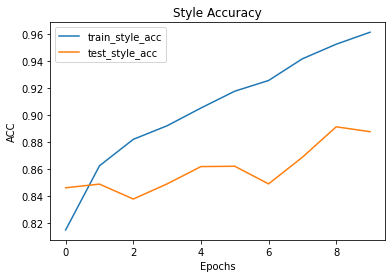

In [34]:
plt.plot(list_font_acc, label="train_style_acc")
plt.plot(list_ts_font_acc, label="test_style_acc")


plt.legend()
plt.xlabel("Epochs")
plt.ylabel("ACC")
plt.title('Style Accuracy')
plt.show()

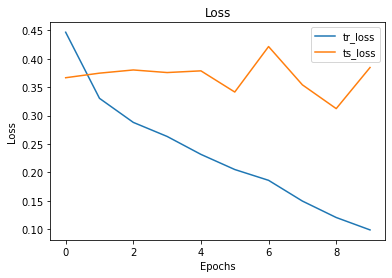

In [35]:
plt.plot(list_tr_loss, label="tr_loss")
plt.plot(list_ts_loss, label="ts_loss")


plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Loss')
plt.show()

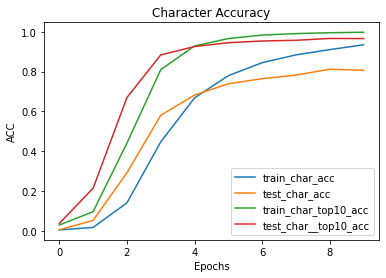

In [42]:
plt.plot(list_char_acc, label="train_char_acc")
plt.plot(list_ts_char_acc, label="test_char_acc")
plt.plot(list_char_10_acc, label="train_char_top10_acc")
plt.plot(list_ts_char_10_acc, label="test_char__top10_acc")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("ACC")
plt.title('Character Accuracy')
plt.show()

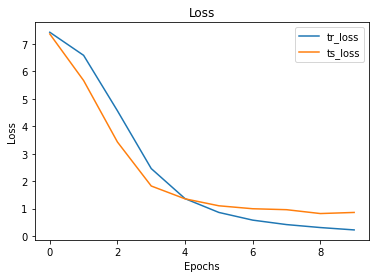

In [43]:
plt.plot(list_tr_loss, label="tr_loss")
plt.plot(list_ts_loss, label="ts_loss")


plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Loss')
plt.show()

In [44]:
#torch.save(model.state_dict(), "D:/caligraphy/test_model3_more_single_char.pth")

In [23]:
#model.load_state_dict(torch.load("D:/caligraphy/test_model3_more_pred.pth"))

<All keys matched successfully>

In [24]:
#model.load_state_dict(torch.load("D:/caligraphy/test_model3_more_single_char.pth"))

<All keys matched successfully>

In [44]:
a,b=evaluate_confusion(model, test_dataloader, criterion, device)

In [45]:
pred=[]
true=[]
for i in a:
    pred.append(i.numpy()[0])
for i in b:
    true.append(i.item())

In [40]:
pred

[4,
 2,
 1,
 2,
 1,
 3,
 2,
 1,
 2,
 4,
 2,
 2,
 2,
 1,
 2,
 0,
 1,
 4,
 0,
 1,
 1,
 2,
 0,
 3,
 1,
 2,
 3,
 3,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 0,
 4,
 2,
 1,
 3,
 1,
 4,
 2,
 3,
 1,
 3,
 1,
 1,
 2,
 3,
 1,
 0,
 4,
 2,
 0,
 1,
 1,
 0,
 2,
 2,
 1,
 3,
 2,
 2,
 3,
 2,
 2,
 2,
 0,
 2,
 2,
 3,
 2,
 1,
 1,
 4,
 2,
 2,
 2,
 2,
 0,
 0,
 1,
 2,
 1,
 3,
 2,
 2,
 4,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 3,
 1,
 1,
 1,
 2,
 4,
 2,
 0,
 2,
 2,
 2,
 1,
 1,
 3,
 0,
 0,
 2,
 2,
 2,
 3,
 2,
 1,
 1,
 1,
 1,
 0,
 2,
 3,
 2,
 0,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 4,
 1,
 1,
 2,
 4,
 4,
 1,
 3,
 1,
 2,
 2,
 1,
 2,
 3,
 3,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 0,
 3,
 2,
 0,
 2,
 1,
 2,
 1,
 1,
 1,
 3,
 1,
 1,
 4,
 2,
 2,
 1,
 2,
 4,
 2,
 1,
 1,
 1,
 2,
 0,
 2,
 2,
 1,
 2,
 0,
 1,
 4,
 3,
 2,
 1,
 1,
 2,
 2,
 2,
 4,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 3,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 0,
 1,
 1,
 2,
 1,
 3,
 1,
 1,
 0,
 1,
 1,
 1,
 2,
 0,
 1,
 1,
 1,
 2,
 2,
 2,
 0,


In [41]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

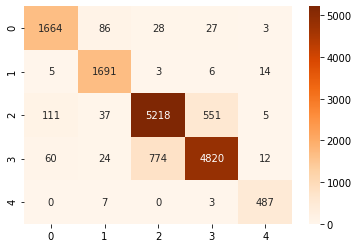

In [48]:
columns = [0,1,2,3,4]

confm = confusion_matrix(true, pred)
df_cm = pd.DataFrame(confm, index=columns, columns=columns)

ax = sn.heatmap(df_cm, cmap='Oranges', annot=True,fmt='g')

In [47]:
confm

array([[1664,   86,   28,   27,    3],
       [   5, 1691,    3,    6,   14],
       [ 111,   37, 5218,  551,    5],
       [  60,   24,  774, 4820,   12],
       [   0,    7,    0,    3,  487]], dtype=int64)

In [22]:
torch.cuda.empty_cache()

In [38]:
def evaluate_confusion(model, iterator, criterion, device):
    
    pred_result=[]
    y_result=[]
    model.eval()
    
    with torch.no_grad():
    
        for x, y1 in iterator:
            for i in y1:
                y_result.append(i)
            x = x.to(device)
            y1 = y1.to(device)
            #y2 = y2.to(device)
        
            optimizer.zero_grad()
                
            outputs = model(x,y1)
        
            top_pred = outputs.argmax(1, keepdim = True).to('cpu')
            for i in top_pred:
                pred_result.append(i)
        
    return pred_result, y_result